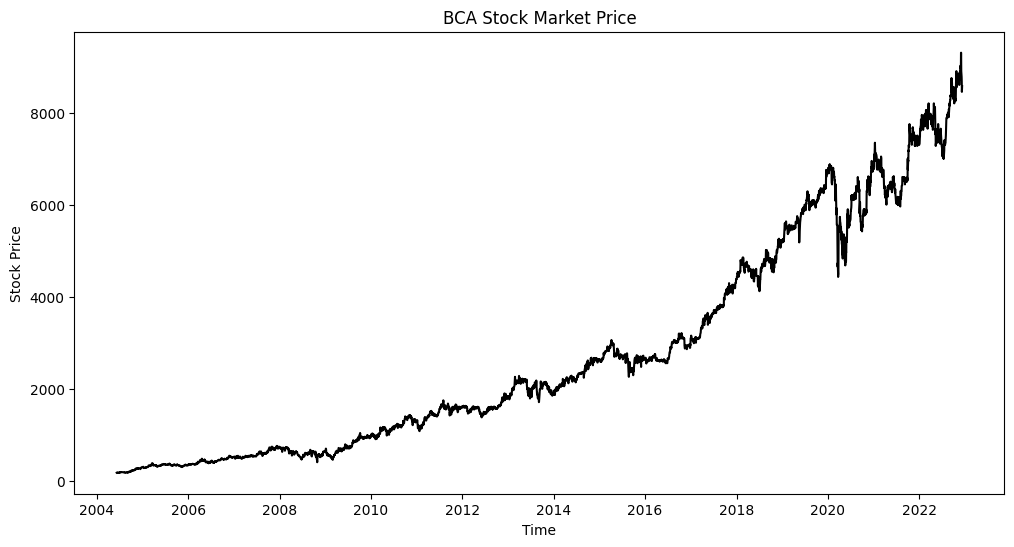

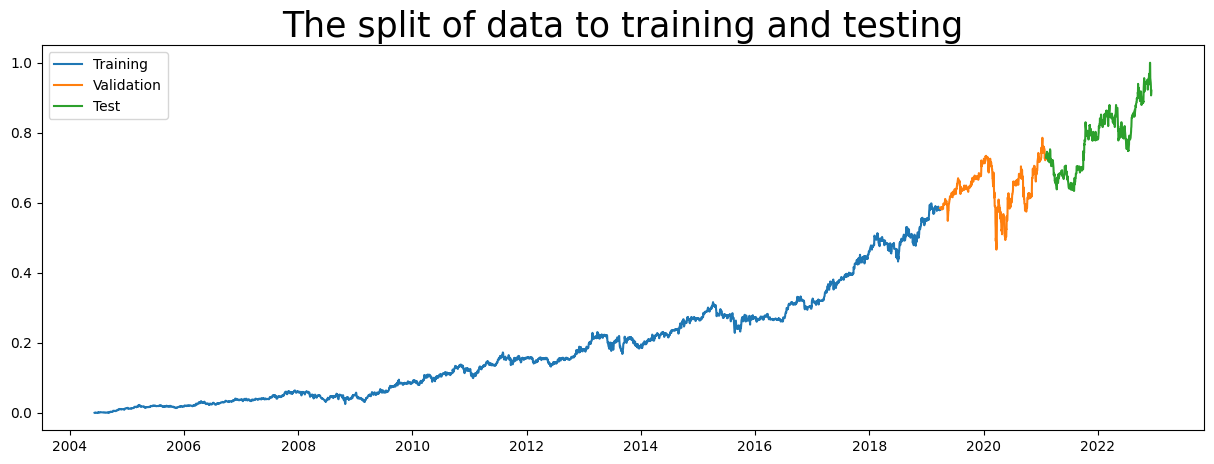

Epoch 1/2000
31/31 [==============================] - 9s 62ms/step - loss: 0.0244 - mae: 0.1683 - val_loss: 0.1934 - val_mae: 0.6193
Epoch 2/2000
31/31 [==============================] - 0s 16ms/step - loss: 0.0211 - mae: 0.1494 - val_loss: 0.1796 - val_mae: 0.5967
Epoch 3/2000
31/31 [==============================] - 0s 13ms/step - loss: 0.0183 - mae: 0.1361 - val_loss: 0.1661 - val_mae: 0.5736
Epoch 4/2000
31/31 [==============================] - 0s 13ms/step - loss: 0.0159 - mae: 0.1278 - val_loss: 0.1530 - val_mae: 0.5504
Epoch 5/2000
31/31 [==============================] - 0s 13ms/step - loss: 0.0139 - mae: 0.1214 - val_loss: 0.1404 - val_mae: 0.5271
Epoch 6/2000
31/31 [==============================] - 0s 13ms/step - loss: 0.0122 - mae: 0.1163 - val_loss: 0.1284 - val_mae: 0.5037
Epoch 7/2000
31/31 [==============================] - 0s 15ms/step - loss: 0.0110 - mae: 0.1124 - val_loss: 0.1174 - val_mae: 0.4816
Epoch 8/2000
31/31 [==============================] - 0s 13ms/step - 

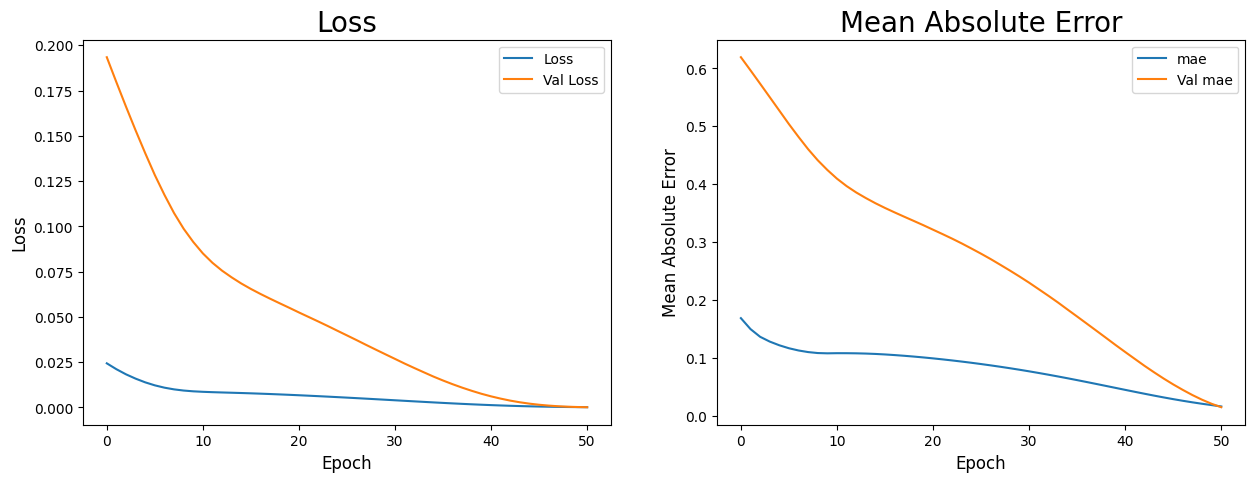

16/16 [==============================] - 2s 3ms/step


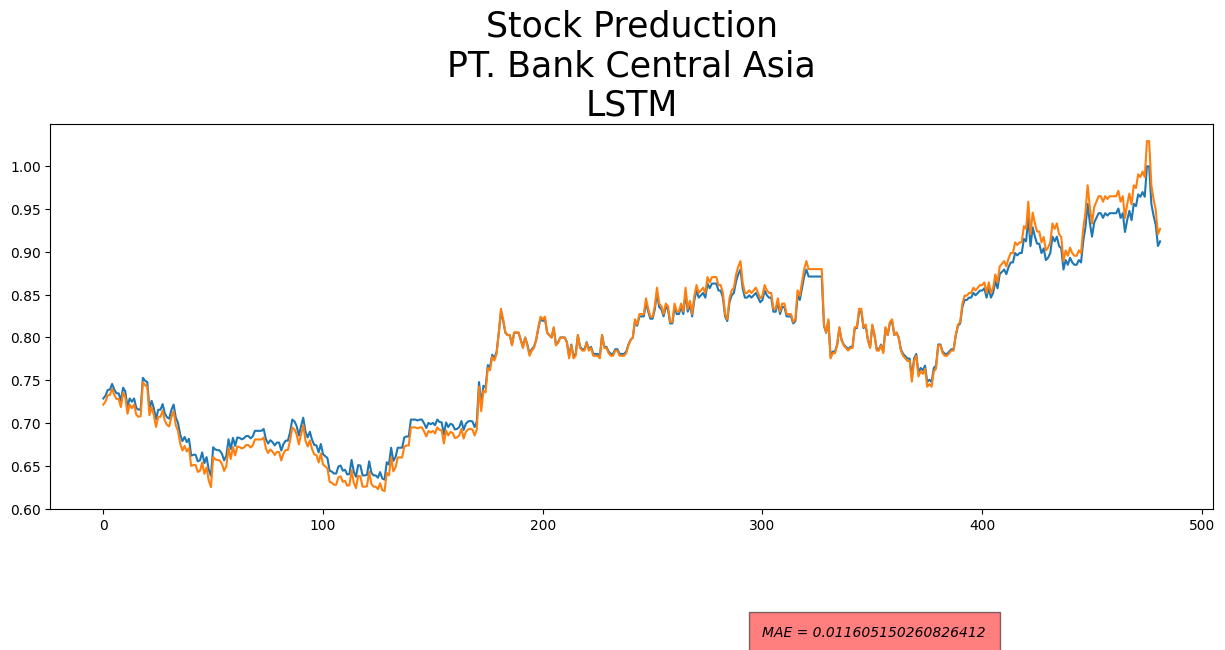

In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import tensorflow as tf
import matplotlib.pyplot as plt 
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM 
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
data = pd.read_csv('../AoL project/datasets/daily/BBCA.csv')
#setting the timestamp as the id
data['timestamp'] = pd.to_datetime(data['timestamp']) 
data = data.set_index('timestamp')
# importing data
# data reduction by removing before the market open until 2004-06-08 as the data changes afterwards
data = data.drop(data.index[range(821)])
data


# data visualization
plt.figure(figsize=(12,6))
plt.plot(data["close"],color="black");
plt.ylabel("Stock Price")
plt.title("BCA Stock Market Price")
plt.xlabel("Time")
plt.show()
ms = MinMaxScaler()
data['close'] = ms.fit_transform(data[['close']])
data
def split_data(df, train_size): 
  size = int(len(df) * train_size)
  train, test = df.iloc[0:size], df.iloc[size:len(df)]
  return train, test
train, temp = split_data(data['close'],0.8) #80% Train
validation,test = split_data(temp,0.5) 
plt.figure(figsize=(15,5))
plt.plot(train)
plt.plot(validation)
plt.plot(test)
plt.legend(labels=['Training', 'Validation','Test'])
plt.title('The split of data to training and testing', fontsize=25)
plt.show()
def split_target(data, lb=1):
    X, y = [], []
    for i in range(len(data) - lb):
        a = data[i:(i + lb), 0]
        X.append(a)
        y.append(data[i + lb, 0])
    return np.array(X), np.array(y)
X_train, y_train = split_target(train.values.reshape(len(train), 1))
X_val, y_val = split_target(validation.values.reshape(len(validation),1)) 
X_test, y_test = split_target(test.values.reshape(len(test), 1))
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val = X_val.reshape((X_val.shape[0],1,X_val.shape[1]))
model = Sequential([LSTM(100, input_shape=(1, 1), return_sequences=True),
                    LSTM(50), 
                    Dense(25, activation='relu'),
                    Dense(1)])
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_mae') is not None and logs.get('val_mae') < 0.015:
      self.model.stop_training = True
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
              metrics=["mae"], 
              loss=tf.keras.losses.Huber())
history = model.fit(X_train, 
                    y_train, 
                    epochs=2000, 
                    batch_size=128, 
                    validation_data=(X_val, y_val), 
                    shuffle=False,
                    callbacks=[Callback()])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Loss','Val Loss'])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss', fontsize=20)

# MAE
ax2.plot(history.history['mae'])
ax2.plot(history.history['val_mae'])
ax2.legend(['mae','Val mae'])
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Mean Absolute Error', fontsize=20)
plt.show()
plt.figure(figsize=(15,5))
y_pred = model.predict(X_test)
y_pred = list(np.reshape(y_pred, (1,len(y_pred)))[0])

X_test = np.reshape(X_test, (len(X_test),1))
X_test = list(np.reshape(X_test, (1,len(X_test)))[0])

plt.plot(X_test)
plt.plot(y_pred)
plt.text(300, 0.45, f"MAE = {mean_absolute_error(y_test, y_pred)}", style='italic', bbox={
        'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.title('Stock Preduction\nPT. Bank Central Asia\nLSTM', fontsize=25)
plt.show()
